### Short description of this project: 
In this project, I will be making use of the UCI HAR Dataset to cluster human activities into different groups. The dataset consists of experiments carried out on a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING,WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers were selected for generating the training data and 30% for the test data. The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only lowfrequency components, therefore a filter with a 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

#### The tasks in the project involves:
- Using K-Means and DBSCAN to do clustering on the given dataset.
- Using a dimensionality reduction technique before using K-Means and DBSCAN on the dataset.
#### Let's jump straight into itt.equency domain.

In [ ]:
# Install the kneed library (and any other necessary libraries)
!pip install kneed

### Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA 
from kneed import KneeLocator
import time
import matplotlib.cm as cm

sns.set()
%matplotlib inline

warnings.filterwarnings('ignore')

### Load the dataset

In [3]:
# File paths
X_train_path = "UCI HAR Dataset/train/X_train.txt"
y_train_path = "UCI HAR Dataset/train/y_train.txt"

X_test_path = "UCI HAR Dataset/test/X_test.txt"
y_test_path = "UCI HAR Dataset/test/y_test.txt"

feature_names_path = "UCI HAR Dataset/features.txt"

# Activity labels
label_to_category = {
        1: "WALKING",
        2: "WALKING_UPSTAIRS",
        3: "WALKING_DOWNSTAIRS",
        4: "SITTING",
        5: "STANDING",
        6: "LAYING"
    }

In [4]:
# Method to load in feature names
def load_feature_names(file_path):
    with open(file_path, 'r') as file:
        feature_names = [line.strip().split(" ")[1] for line in file]
    return feature_names

# A method to load the labels 
def load_labels_from_txt(filepath):
    """
    Extracts labels from a .txt file, where each line in the file is a label.
    
    Parameters:
    filepath (str): The path to the .txt file containing the labels.
    
    Returns:
    pd.Series: A pandas Series containing the labels as integers.
    """
    with open(filepath, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # Convert the list of labels into a pandas Series
    labels_series = pd.Series(labels)
    return labels_series

# A method to load data from txt
def load_data_from_txt(data_file_path, labels_file_path, feature_names_path, output_file_name):
    """
    Load data from a .txt file into a pandas DataFrame: Save and return DataFrame.

    Parameters:
    data_file_path (str): The path to the .txt file to load.
    labels_file_path (str): The path to the .txt file containing the labels
    feature_names_path: The path to the .txt file containing the feature names
    output_file_name: The name under which the transformed file should be saved

    Returns:
    pd.DataFrame: A pandas DataFrame containing the data from the .txt file.
    """
    # Get feature names
    cols = load_feature_names(feature_names_path)
    with open(data_file_path, 'r') as file:
        data = [line.strip().split() for line in file]  
    # Convert the string data to floats and filter out empty strings 
    processed_data = [[float(item) for item in row if item] for row in data]
    dataset = pd.DataFrame(processed_data, columns=cols)

    # Convert the labels to their corresponding category names
    labels = load_labels_from_txt(labels_file_path)
    labels = labels.map(label_to_category)
    # append labels to dataset
    dataset["activity"] = labels
    dataset.to_csv(output_file_name)

    return dataset


In [148]:
train_data_url = ('https://raw.githubusercontent.com/abdulaihalidu/Abo-Akademi-Machine-Learning/main/Clustering%20Human%20Activities/train_data.csv')
test_data_url = ('https://raw.githubusercontent.com/abdulaihalidu/Abo-Akademi-Machine-Learning/main/Clustering%20Human%20Activities/test_data.csv')

# Load datasets
# train_data = load_data_from_txt(X_train_path, y_train_path, feature_names_path, "train_data.csv")
# test_data = load_data_from_txt(X_test_path, y_test_path, feature_names_path, "test_data.csv")

# For convenience, I have saved copies of the transformed dataset to GitHub. Let's fetch that data
train_data = pd.read_csv(train_data_url, index_col=0)
test_data = pd.read_csv(test_data_url, index_col=0)

#### Data exploration
- Check shape of train/test dataset
- Check for null values
- view first few rows of the dataset to have an understanding of what the dataset looks like

In [149]:
# To avoid writing the same blocks of code, let's define a function for exploring the dataset
def explore_dataset(dataset, title="training") -> None:
    print("=" * 30, f"Summary of the {title} dataset", "=" * 30)
    print(f"The shape of the {title} dataset is: {dataset.shape}")
    print(f"Contains null values? {dataset.isnull().any().any()}")
    print()

In [150]:
explore_dataset(train_data)
explore_dataset(test_data, title="test")

============================== Summary of the training dataset ==============================
The shape of the training dataset is: (7352, 562)
Contains null values? False

============================== Summary of the test dataset ==============================
The shape of the test dataset is: (2947, 562)
Contains null values? False



#### Checking the distribution of activities

In [151]:
def display_activity_distribution(df, column_name) -> None:
    """
    Displays a pie chart and a histogram showing the distribution of the data according to the col specifieed

    Parameters:
    - df: pandas DataFrame
    - column_name: str, the name of the column to analyze

    Returns:
    - None
    """
    # Check if the column exists in the DataFrame
    if column_name not in df.columns:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
        return

    # Calculate value counts for the column
    value_counts = df[column_name].value_counts()

    # Setup the figure and axes for the subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))

    # Pie chart
    wedges, texts, autotexts = ax[0].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
    ax[0].set_title(f'Pie Chart of {column_name}')
    ax[0].set_ylabel('')  # Hide the y-label as it's unnecessary for pie charts

    # Histogram-like bar chart
    ax[1].bar(value_counts.index, value_counts, color=colors)
    ax[1].set_title(f'Histogram of {column_name}')
    ax[1].set_xlabel(column_name)
    ax[1].set_ylabel('Frequency')
    ax[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

##### Distribition of the activities recorded in the training dataset

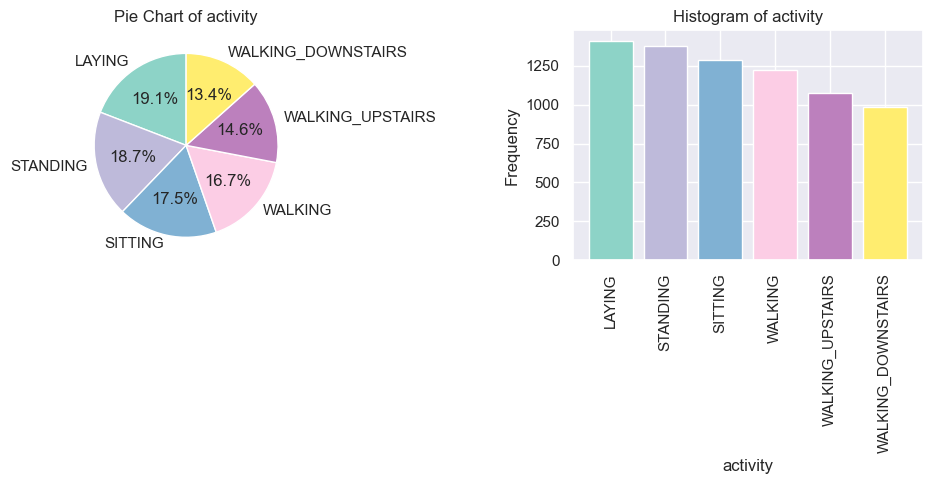

In [152]:
display_activity_distribution(train_data, "activity")

#### Distribition of the activities recorded in the test dataset¶

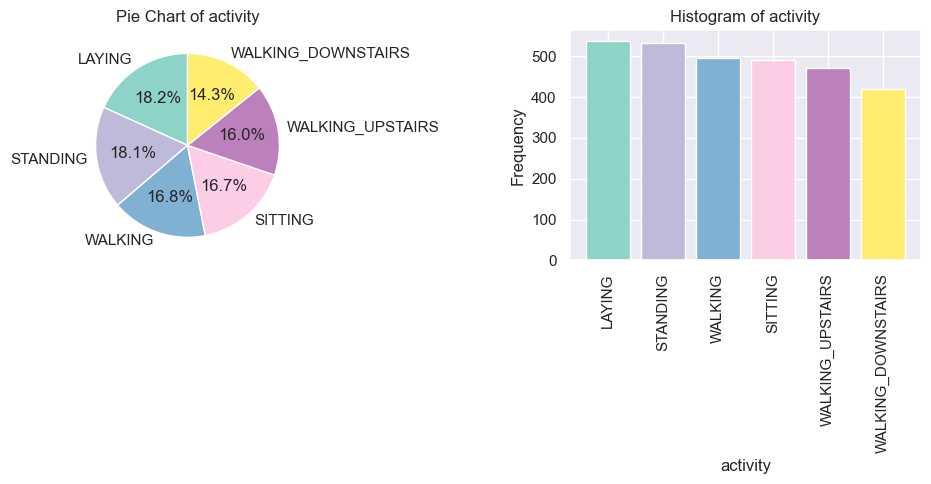

In [153]:
display_activity_distribution(test_data, "activity")

In [154]:
# View first few rows of the train_dataset
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


In [155]:
# View first few rows of the test dataset
test_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,STANDING


#### Observations:
- The dataset contains no null values (both the training and test sets). Good news!
- The dataset has indeed, been normalized into the range [-1, 1] as per the description of the dataset
- We can observe from the distribution of the train and test data that majority of the activities recorded were that of the participants LAYING down, followed by STANDING, SITTING, WALKING, ... (In that order).
- Since there are no necessary preprocessing to be performed, we can jump straight into performing the clustering

### Clustering:
- We will use the train data to fit the clustering models and use the test data to determine how well the fitted models perform
- We will also need to assign the target variable "activity" and drop it from the features vector

In [156]:

try:  # Using a try block to ensure that no error is thrown if this cell is accidentally re-run without running the cells above
    y_train = train_data.activity
    # drop target from the feature vector
    train_data.drop(['activity'], axis=1, inplace=True)
except:
    pass
try:  
    y_test = test_data.activity
    # drop target from the feature vector
    test_data.drop(['activity'], axis=1, inplace=True)
except:
    pass
    
print(f"Shape of train data: feature vector shape: {train_data.shape}, target shape: {y_train.shape}")
print(f"Shape of test data: feature vector shape: {test_data.shape}, target shape: {y_test.shape}")


Shape of train data: feature vector shape: (7352, 561), target shape: (7352,)
Shape of test data: feature vector shape: (2947, 561), target shape: (2947,)


#### K-Means clustering
Since K-Means algorithms requires that we specify the number of cluster prior to running the clustering algorithms, I will be making use of two main techniques to find the optimal number of clusters:
- The elbow method
- and the Silhoutte analysis method

#### The elbow method for finding the right number of clusters

In [157]:
def elbow_method_for_best_k(data):
    clusters = range(1, 10)
    inertia_arr = []

    for c in clusters:
        cluster = KMeans(n_clusters=c, random_state=42).fit(data)
        inertia_arr.append(cluster.inertia_)

    plt.plot(clusters, inertia_arr, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Choosing Best k with Inertia')
    plt.grid(True)
    plt.show()

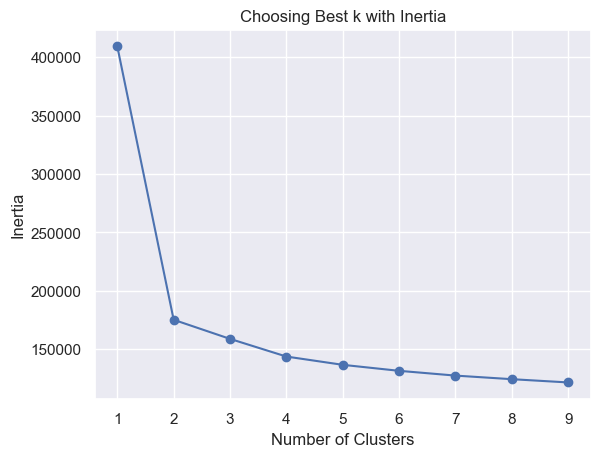

In [158]:
elbow_method_for_best_k(train_data)

### The Silhoutte analysis method for finding the right number of clusters

In [159]:
def find_best_k_silhouette(data, k_min=2, k_max=10):
    """
    Finds the best k value for K-Means clustering using silhouette analysis.

    Parameters:
    - data: array-like, shape (n_samples, n_features)
    - k_min: int, minimum number of clusters to try
    - k_max: int, maximum number of clusters to try

    Returns:
    - None
    """
    silhouette_scores = []
    ks = range(k_min, k_max + 1)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'For n_clusters = {k}, the silhouette score is {silhouette_avg:.4f}.')

    best_k = ks[silhouette_scores.index(max(silhouette_scores))]
    print(f'Best number of clusters based on silhouette score: {best_k}')

    # Plotting the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(ks, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Analysis For Optimal k')
    plt.grid(True)
    plt.show()


For n_clusters = 2, the silhouette score is 0.4852.
For n_clusters = 3, the silhouette score is 0.3319.
For n_clusters = 4, the silhouette score is 0.1875.
For n_clusters = 5, the silhouette score is 0.1707.
For n_clusters = 6, the silhouette score is 0.1466.
For n_clusters = 7, the silhouette score is 0.1292.
For n_clusters = 8, the silhouette score is 0.1232.
For n_clusters = 9, the silhouette score is 0.1182.
For n_clusters = 10, the silhouette score is 0.1136.
Best number of clusters based on silhouette score: 2


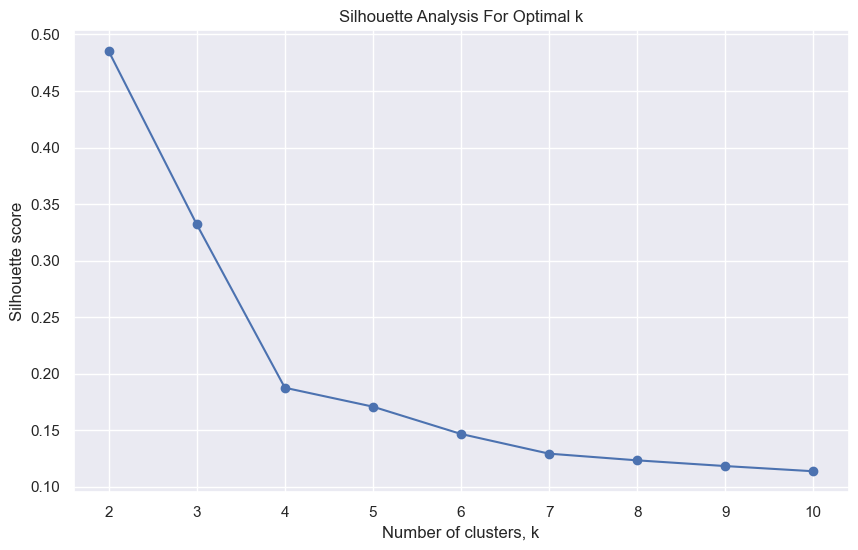

In [160]:
find_best_k_silhouette(train_data)

#### The value of k that gives the highest average silhouette score suggests that the clustering configuration is appropriately dense and well-separated than other k values.
- From the graph above, it can be observed that k=2 gives the highest silhoutte score, suggesting the use of 2 as the optimal value of k (number of clusters)
- This value, agrees with that of the elbowl method (in which we also get the best k value as 2)

#### Using k=2 (number of clusters = 2) to perform K-Means clustering

In [161]:
def perform_kmeans_and_visualize_with_pca(train_data, test_data, n_clusters=2, n_components=3):
    """
    Performs K-Means clustering on the provided training dataset, predicts cluster labels for the test dataset,
    reduces the dimensionality to 3D using PCA, and visualizes the results for both train and test datasets.

    Parameters:
    - train_data: array-like or pandas DataFrame, shape (n_samples, n_features)
        The input data to perform clustering and dimensionality reduction on for training.
    - test_data: array-like or pandas DataFrame, shape (n_samples, n_features)
        The input data for testing.
    - n_clusters: int, optional, default=2
        The number of clusters to form as well as the number of centroids to generate.
    - n_components: int, optional, default=3
        The number of principal components to reduce the data to for visualization.

    Returns:
    - train_labels: array, shape (n_samples,)
        Cluster labels for each point in the train dataset.
    - test_labels: array, shape (n_samples,)
        Cluster labels for each point in the test dataset.
    - kmeans_model: KMeans object
        The fitted KMeans model.
    """
    # Fit K-Means on the train data
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    # Measure time taken to fit the model
    start_time = time.time()
    kmeans_model.fit(train_data)
    end_time = time.time()
    execution_time = end_time - start_time
    train_labels = kmeans_model.predict(train_data)
    test_labels = kmeans_model.predict(test_data)

    # Reduce train and test data dimensionality for visualization
    pca = PCA(n_components=n_components)
    reduced_train_data = pca.fit_transform(train_data)
    reduced_test_data = pca.transform(test_data)
    
    # Visualization
    fig = plt.figure(figsize=(16, 8))
    
    # Plot for train data
    ax = fig.add_subplot(121, projection='3d')
    for label in set(train_labels):
        cluster_data = reduced_train_data[train_labels == label]
        ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Train Cluster {label}')
    ax.set_title('Train Data')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    
    # Plot for test data
    ax = fig.add_subplot(122, projection='3d')
    for label in set(test_labels):
        cluster_data = reduced_test_data[test_labels == label]
        ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Test Cluster {label}')
    ax.set_title('Test Data')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()

    plt.show()

    return train_labels, test_labels, kmeans_model, execution_time

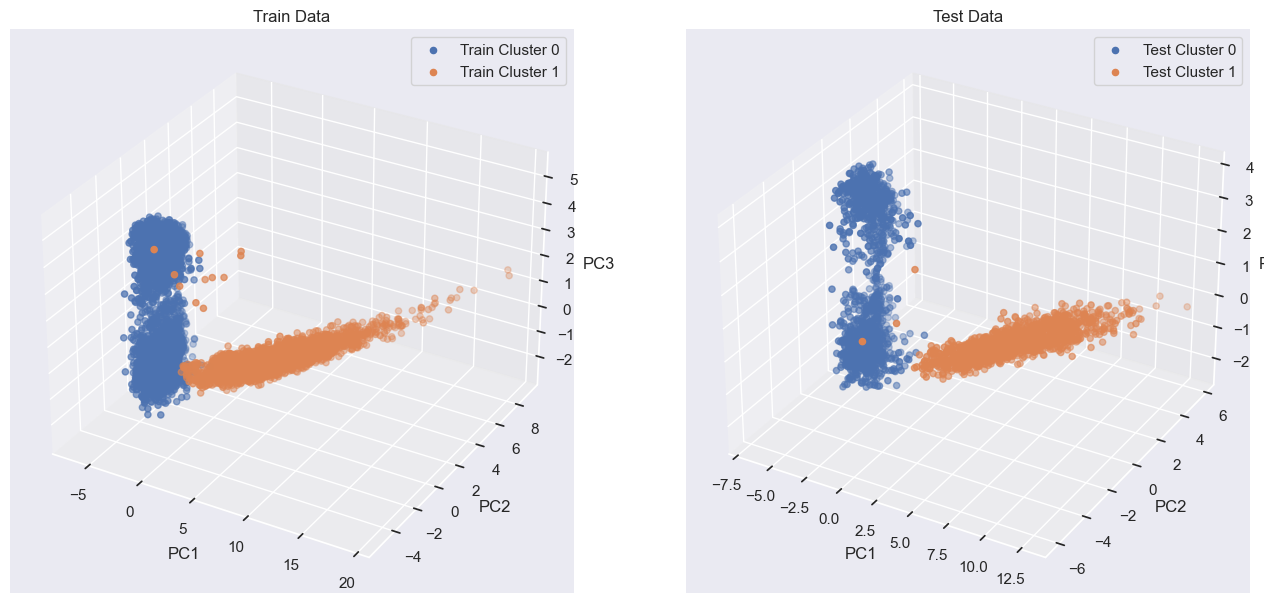

Execution time for KMeans algorithm on the train dataset: 0.38 seconds


In [162]:
kmeans_train_labels, kmeans_test_labels, kmeans_model, execution_time_KM_orginal_dataset = perform_kmeans_and_visualize_with_pca(train_data, test_data)
print(f"Execution time for KMeans algorithm on the train dataset: {execution_time_KM_orginal_dataset:.2f} seconds")

### Clustering with DBSCAN
- Since DBSCAN doesn't predict, we will combine the train and test sets and fit the dbscan model on it
#### First let's find the best hyperparameter values for the DBSCAN algorithm

In [163]:
train_test_dataset = pd.concat([train_data, test_data], axis=0)
train_test_labels = pd.concat([y_train, y_test])
train_test_dataset.shape

(10299, 561)

In [164]:
def find_optimal_eps(data, n_neighbors=4):
    """
    Finds the optimal eps value for DBSCAN using the k-distance graph and the KneeLocator.
    
    Parameters:
    - data: array-like or pandas DataFrame, shape (n_samples, n_features)
        The input data to compute the k-distance graph for.
    - n_neighbors: int, optional, default=4
        The number of neighbors to use for k-nearest neighbors computation.
    
    Returns:
    - optimal_eps: float
        The estimated optimal eps value for DBSCAN.
    """
    # Compute the nearest neighbors
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    
    # Sort the distances
    sorted_distances = np.sort(distances[:, n_neighbors-1], axis=0)
    reversed_distances = sorted_distances[::-1]  # Reverse to find the elbow using KneeLocator
    
    # Use KneeLocator to find the elbow point, which suggests an optimal eps
    knee_locator = KneeLocator(range(len(reversed_distances)), reversed_distances, curve='convex', direction='decreasing')
    optimal_eps = reversed_distances[knee_locator.knee]
    
    # Plot (optional, for verification)
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances)
    plt.title(f'K-distance Graph, k={n_neighbors}')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {n_neighbors}-th nearest neighbor')
    plt.grid(True)
    plt.plot([knee_locator.knee, knee_locator.knee], [0, optimal_eps], 'r--')
    plt.plot([0, knee_locator.knee], [optimal_eps, optimal_eps], 'r--')
    plt.show()
    
    return optimal_eps

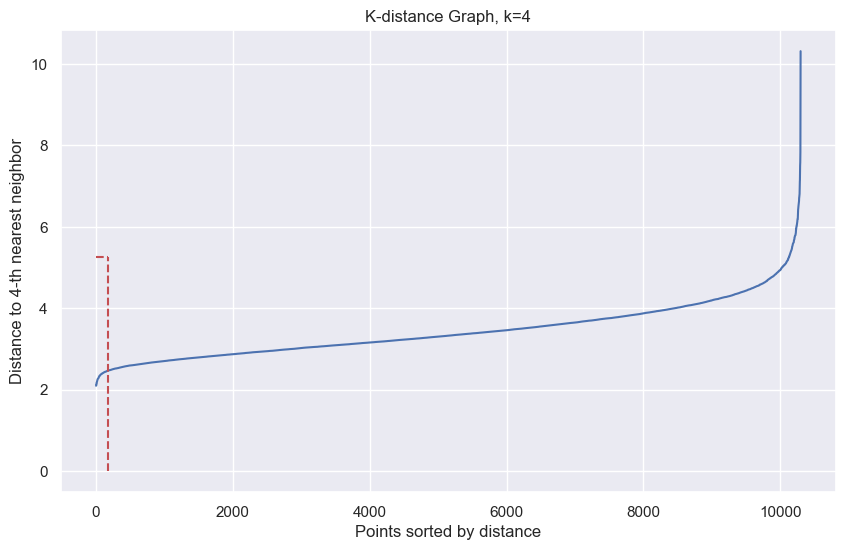

In [165]:
optimal_eps = find_optimal_eps(train_test_dataset)

In [166]:
print(f"The optimal eps value found is: {optimal_eps}")

The optimal eps value found is: 5.258115084848028


In [167]:
def find_best_dbscan_params(data, eps_values, min_samples_values):
    best_score = -1
    best_params = {'eps': None, 'min_samples': None}
    for eps in eps_values:
        for min_samples in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
            labels = db.labels_
            # Number of clusters in labels, ignoring noise if present
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            print(n_clusters_)
            # Proceed to calculate the silhouette score only if there are more than 1 cluster and less than len(data) - 1 noise points
            if n_clusters_ > 1 and n_clusters_ < len(data) - 1:
                score = silhouette_score(data, labels)
                print(f"EPS: {eps}, min_samples: {min_samples}, Silhouette Score: {score:.4f}")
                if score > best_score:
                    best_score = score
                    best_params['eps'] = eps
                    best_params['min_samples'] = min_samples

    return best_score, best_params

In [168]:

eps_values = [optimal_eps]  
min_samples_values = [100, 500, 525,  550, 600, 700, 800, 900, 950, 1000, 1100,  1200]   
best_score, best_params = find_best_dbscan_params(train_test_dataset, eps_values, min_samples_values)
print(f"Best score: {best_score}, Best params: {best_params}")

1
1
1
2
EPS: 5.258115084848028, min_samples: 550, Silhouette Score: 0.3764
2
EPS: 5.258115084848028, min_samples: 600, Silhouette Score: 0.3706
2
EPS: 5.258115084848028, min_samples: 700, Silhouette Score: 0.3618
2
EPS: 5.258115084848028, min_samples: 800, Silhouette Score: 0.3571
2
EPS: 5.258115084848028, min_samples: 900, Silhouette Score: 0.3518
2
EPS: 5.258115084848028, min_samples: 950, Silhouette Score: 0.3490
2
EPS: 5.258115084848028, min_samples: 1000, Silhouette Score: 0.3465
2
EPS: 5.258115084848028, min_samples: 1100, Silhouette Score: 0.3377
2
EPS: 5.258115084848028, min_samples: 1200, Silhouette Score: 0.3349
Best score: 0.3764005197867222, Best params: {'eps': 5.258115084848028, 'min_samples': 550}


#### From the experiments above, we have been able to determine the optimal hyperparamers for the DBSCAN algorithms:
- optimal eps: 5.258115084848028
- optimal min_samples: 550
#### Let's proceed to run the DSCAN algorithm for clustering our dataset

In [169]:
# CONSTANTS
EPS = best_params["eps"]
MIN_SAMPLES = best_params["min_samples"]

In [170]:
def perform_dbscan_and_visualize_with_pca(data, eps=EPS, min_samples=MIN_SAMPLES, n_components=3):
    """
    Performs DBSCAN clustering on the provided dataset, reduces the dimensionality to 3D using PCA,
    and visualizes the results in a 3D plot.

    Parameters:
    - data: array-like or pandas DataFrame, shape (n_samples, n_features)
        The input data to perform clustering and dimensionality reduction on.
    - eps: float, optional, default=0.5
        The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples: int, optional, default=5
        The number of samples in a neighborhood for a point to be considered as a core point.
    - n_components: int, optional, default=3
        The number of principal components to reduce the data to for visualization.

    Returns:
    - labels: array, shape (n_samples,)
        Cluster labels for each point in the dataset. Noisy samples are given the label -1.
    """
    # Perform DBSCAN clustering and measure the execution time
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
    
    start_time = time.time()
    labels = dbscan_model.fit_predict(data)
    end_time = time.time()
    execution_time = end_time - start_time

    # find number of samples classified as noise
    noise_samples_count = np.sum(labels == -1)

    # Reduce data dimensionality for visualization
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)

    # Visualization in 3D
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = set(labels)
    # Generate a color palette, with a separate color for noise (label -1)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise
            col = [0, 0, 0, 0.5]

        class_member_mask = (labels == k)
        xyz = reduced_data[class_member_mask]
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], 'o', color=tuple(col), edgecolor='k', s=50, label=f'Cluster {k}' if k != -1 else 'Noise')

    ax.set_title('DBSCAN Clustering')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
    plt.show()

    return labels, dbscan_model, execution_time, noise_samples_count

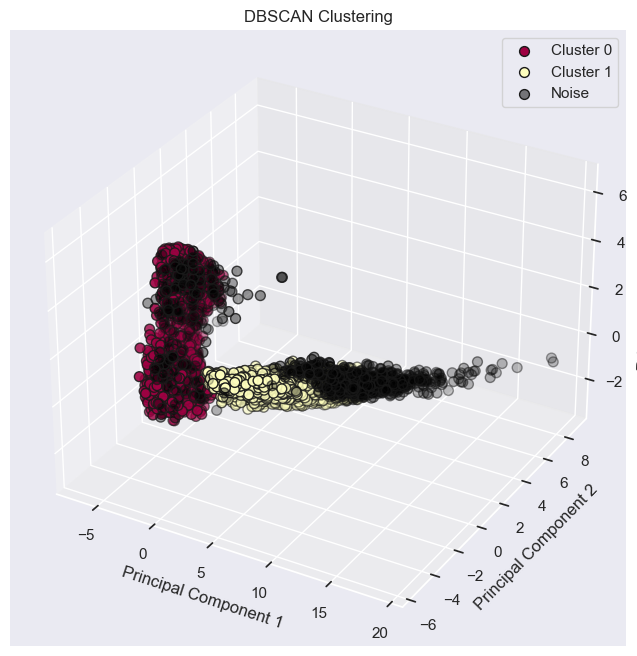

Execution time for dbscan algorithm on the original dataset: 1.44 seconds
Number of samples classified as noise by dbscan on the original dataset: 892


In [171]:
dbscan_labels, dbscan_model, execution_time_dbscan_original_dataset, noise_samples_cnt = perform_dbscan_and_visualize_with_pca(train_test_dataset)
print(f"Execution time for dbscan algorithm on the original dataset: {execution_time_dbscan_original_dataset:.2f} seconds")
print(f"Number of samples classified as noise by dbscan on the original dataset: {noise_samples_cnt}")

### Performing dimentionality reduction with PCA
- We will essentially keep 90% of the information in the original dataset. For this, we will set the n_components parameter to 0.9 

In [172]:
def reduce_dimensionality(dataset, n_components=0.9):
    """
    Reduce the dimensionality of the given dataset using PCA, aiming to retain a certain percentage of the variance.

    Parameters:
    - dataset (array-like, shape (n_samples, n_features)): The dataset to perform PCA on.
    - n_components (float, 0 < n_components < 1): The percentage of variance to keep. Defaults to 0.9 for 90% variance.

    Returns:
    - reduced_dataset (array, shape (n_samples, n_reduced_features)): The dataset after dimensionality reduction.
    """
    pca = PCA(n_components=n_components)
    reduced_dataset = pca.fit_transform(dataset)
    #print(f"Shape of transformed dataset with PCA: {reduced_dataset.shape}")
    return reduced_dataset

In [173]:
reduced_dim_train_dataset = reduce_dimensionality(train_data)
reduced_dim_test_dataset = reduce_dimensionality(test_data)
reduced_dim_combined_dataset = reduce_dimensionality(train_test_dataset)
print(f"New dimension of train set after performing dimentionality reduction: {reduced_dim_train_dataset.shape}")
print(f"New dimension of test set after performing dimentionality reduction: {reduced_dim_test_dataset.shape}")
print(f"New dimension of combined set after performing dimentionality reduction: {reduced_dim_combined_dataset.shape}")

New dimension of train set after performing dimentionality reduction: (7352, 34)
New dimension of test set after performing dimentionality reduction: (2947, 34)
New dimension of combined set after performing dimentionality reduction: (10299, 36)


#### Essentially, PCA has reduced the dimentionality of the original combined dataset from 561 to 36, and the train/test sets to 34
- Hence, we'd expect both KMeans and DBSCAN to be more efficient on the reduced dataset in terms of computational time
- For clarity, I will append rd (i.e, reduced dataset) to the labels and model to help identify them as the results obtained from applying PCA to reduce the dimension of the original dataset

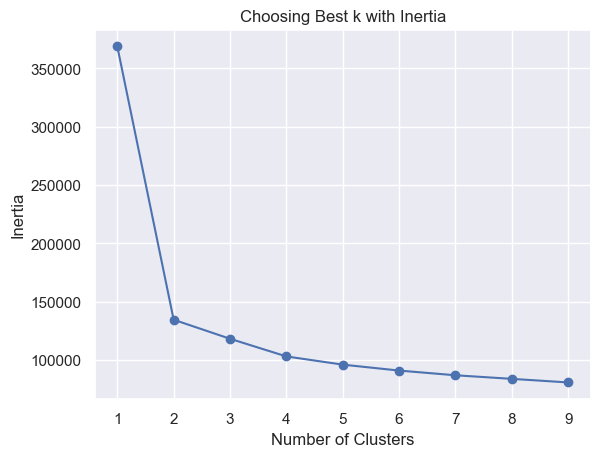

In [174]:
# Let's call the elbow method to determine the best k value for the reduced dataset
elbow_method_for_best_k(reduced_dim_train_dataset)

##### The best value for k (number of clusters) still remains 2 for the reduced dataset

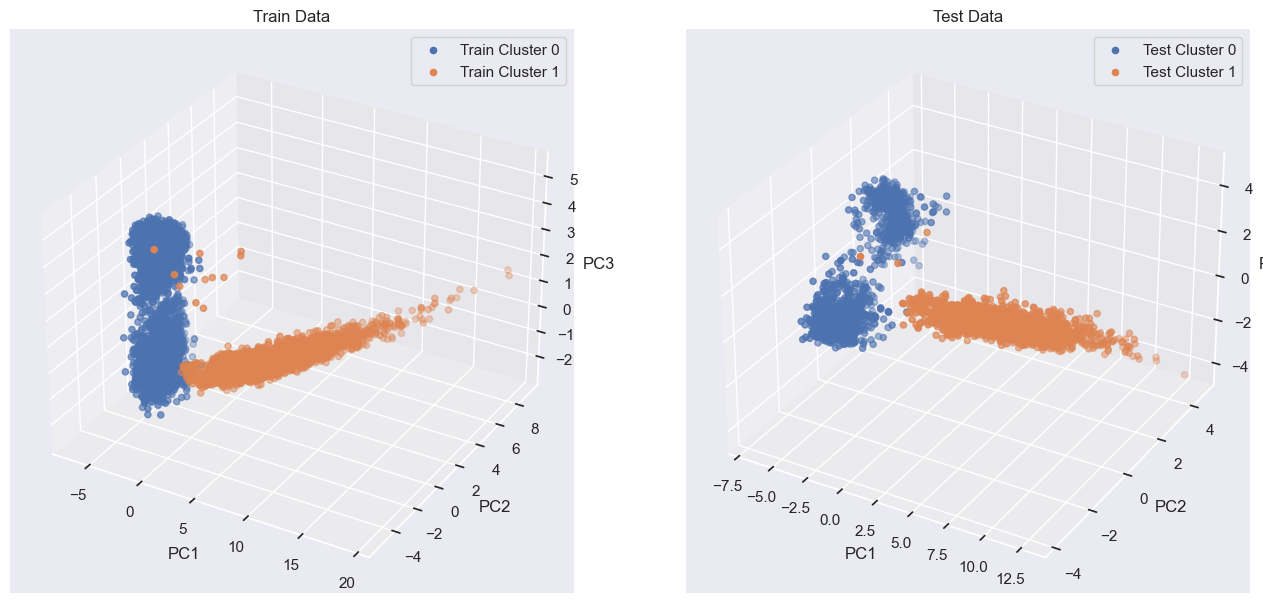

Execution time for KMeans algorithm on the reduced dataset: 0.06 seconds


In [175]:
_, kmeans_train_labels_rd, kmeans_model_rd, execution_time_KM_reduced_dataset = perform_kmeans_and_visualize_with_pca(reduced_dim_train_dataset,
                                                                                                            reduced_dim_test_dataset)
print(f"Execution time for KMeans algorithm on the reduced dataset: {execution_time_KM_reduced_dataset:.2f} seconds")

In [176]:
print(f"Kmeans found the same cluster results for both the original train and reduced train dataset? \
{np.array_equal(kmeans_train_labels, kmeans_train_labels_rd)}")
print(f"Kmeans found the same cluster results for both the original test and reduced test dataset? \
{np.array_equal(kmeans_train_labels, kmeans_train_labels_rd)}")

Kmeans found the same cluster results for both the original train and reduced train dataset? False
Kmeans found the same cluster results for both the original test and reduced test dataset? False


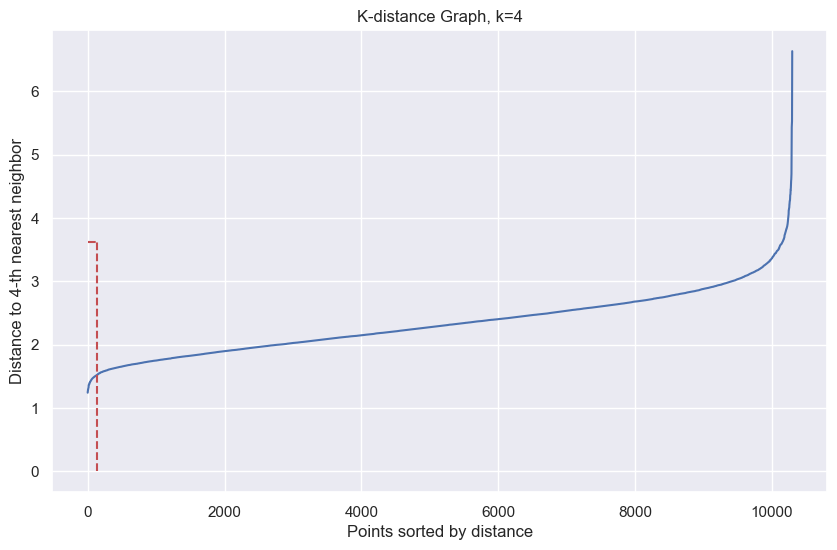

In [177]:
optimal_eps_rd = find_optimal_eps(reduced_dim_combined_dataset)

In [178]:
print(f"The optimal eps value found is: {optimal_eps_rd}")

The optimal eps value found is: 3.623512849080367


In [179]:
eps_values_rd = [optimal_eps_rd]  
min_samples_values_rd = [5, 10, 15, 20, 30, 50, 100,500, 1000, 1200]   
best_score_rd, best_params_rd = find_best_dbscan_params(reduced_dim_combined_dataset, eps_values_rd, min_samples_values_rd)
print(f"Best score: {best_score_rd}, Best params: {best_params_rd}")

2
EPS: 3.623512849080367, min_samples: 5, Silhouette Score: 0.2377
1
1
2
EPS: 3.623512849080367, min_samples: 20, Silhouette Score: 0.4746
3
EPS: 3.623512849080367, min_samples: 30, Silhouette Score: 0.4342
2
EPS: 3.623512849080367, min_samples: 50, Silhouette Score: 0.4482
2
EPS: 3.623512849080367, min_samples: 100, Silhouette Score: 0.4251
2
EPS: 3.623512849080367, min_samples: 500, Silhouette Score: 0.2627
1
1
Best score: 0.4745749378873427, Best params: {'eps': 3.623512849080367, 'min_samples': 20}


In [180]:
# Constants
EPS_RD = best_params_rd["eps"]
MIN_SAMPLES_RD = best_params_rd["min_samples"]

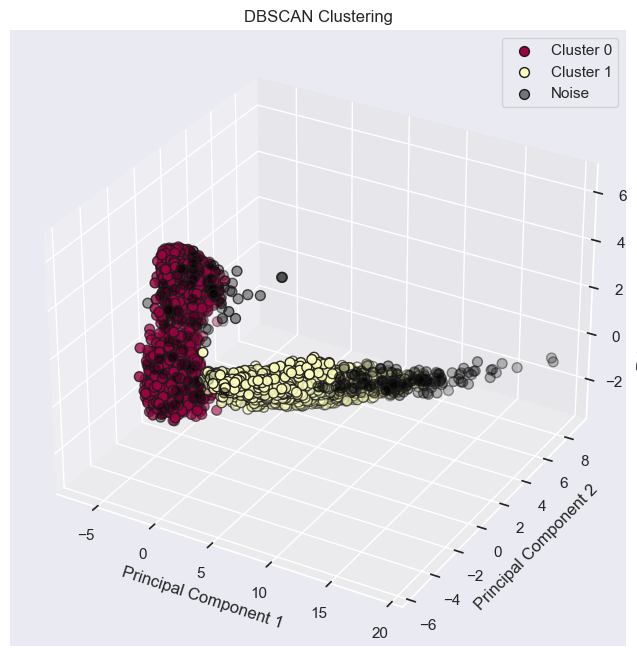

Execution time for KMeans algorithm on the reduced dataset: 0.25 seconds
Number of samples classified as noise by dbscan on the reduced dataset: 244


In [181]:
dbscan_labels_rd, dbscan_model_rd, execution_time_dbscan_reduced_dataset, noise_samples_cnt = perform_dbscan_and_visualize_with_pca(
                                                                                                                    reduced_dim_combined_dataset, 
                                                                                                                eps=EPS_RD, min_samples=MIN_SAMPLES_RD)

print(f"Execution time for KMeans algorithm on the reduced dataset: {execution_time_dbscan_reduced_dataset:.2f} seconds")
print(f"Number of samples classified as noise by dbscan on the reduced dataset: {noise_samples_cnt}")

In [182]:
print(f"DBSCAN found the same cluster results for both the original and reduced dataset? {np.array_equal(dbscan_labels,dbscan_labels_rd)}")

DBSCAN found the same cluster results for both the original and reduced dataset? False


In [183]:
execution_times = {
    "Kmeans_execution_time_original_dataset": [execution_time_KM_orginal_dataset],
    "Kmeans_execution_time_reduced_dataset": [execution_time_KM_reduced_dataset],
    "DBSCAN_original_execution_time_dataset": [execution_time_dbscan_original_dataset],
    "DBSCAN_reduced_execution_time_dataset": [execution_time_dbscan_reduced_dataset]
}

#execution_times
cols = ["Execution time (seconds)"]
execution_times_df = pd.DataFrame(execution_times).T
execution_times_df.columns = cols
execution_times_df

,Execution time (seconds)
Kmeans_execution_time_original_dataset,0.378314
Kmeans_execution_time_reduced_dataset,0.062881
DBSCAN_original_execution_time_dataset,1.435071
DBSCAN_reduced_execution_time_dataset,0.247915


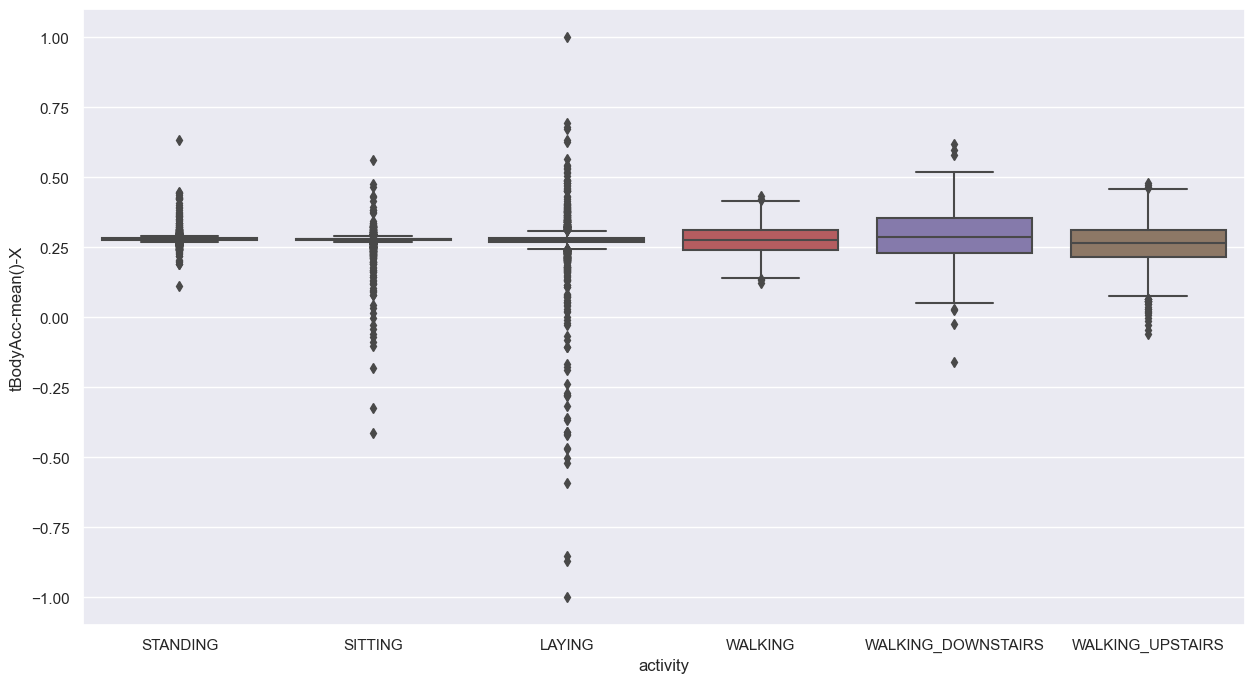

In [184]:
def box_plot_tBodyAcc() -> None:
    plt.figure(figsize=(15, 8))
    sns.boxplot(y=train_test_dataset["tBodyAcc-mean()-X"], x=train_test_labels)
    plt.show()
box_plot_tBodyAcc()

### Comments on the results obtained:
- By using techniques such as the the elbow and silhoutte methods, we have been able to determine the best hyperparameters for both the KMeans and DBSCAN algorithms
- Both the KMeans and DBSCAN algorithms  found two clusters: This suggests that the dataset is mainly classified into Stationary actions such as (STANDING, SITTING, LAYING) and motional activities such as (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS) as can be seen in the boxplot above

#### Comments on  performance
- By visualing the results on a 3D plot, it can be seen that Kmeans tries to classifier every single data point into one of the available clusters. In doing so, it classifies noise as well. Overall, Kmeans performed better on the reduced dataset through the incorporation of PCA.
- DBSCAN on the other hand, can handle noise in the dataset. In the orginal dataset, DBSCAN identified 892 data points as noise alongside the two clusters, while in the reduced dataset, the number of data points identified as noise reduced to 244.
- From the perspective of computational complexity, employing PCA was helpful as it reduced the execution time of KMeans by a factor of about 7, while the execution time of DBSCAN reduced by a factor of about 5.
- The Silhoutte score for the DBSCAN on the original dataset was about 3.7 while on the reduced dataset was about 4.7, which suggests that performing dimentionality reduction enhanced the clustering algorithm of DBSCAN.
##### Overall, Kmeans was computationally faster than DBSCAN, while DBSCAN was better at identifying the the clusters since it avoided classifying noise samples into any of the available clusters

### Reasons for choosing PCA for performing the dimensional reduction
- Simplicity: PCA is conceptually straightforward and relies on linear algebra operations that are well-understood and efficiently implemented in most data analysis libraries.
- Interpretability: PCA transforms the original features into orthogonal components that explain the variance in the data. These principal components can be examined to understand the directions of maximum variance in the data, which can provide insights into the underlying structure of the dataset.
- PCA creates orthogonal components, which means the resulting features are uncorrelated. This is particularly useful in linear models where multicollinearity can be a problem.